# Nachalat Yitzhak Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from scipy import stats
import contextily as ctx
import os

In [3]:
neigh_shp_path = '/Users/noamgal/Downloads/NeighborhoodNew2/neighborhood_new2.shp'
bus_shp_path = '/Users/noamgal/Downloads/export_20240626_004309/Active business license.shp'
gdb_path = '/Users/noamgal/Downloads/245117b2-9277-485e-b353-80e83ce75dfa.gdb'
# Load shapefiles to geopandas
neigh_gdf = gpd.read_file(neigh_shp_path)
bus_gdf = gpd.read_file(bus_shp_path)
walk_survey = gpd.read_file(gdb_path)

In [4]:
print(neigh_gdf.columns)
print(bus_gdf.columns)

Index(['msshchuna', 'shemshchun', 'ShapeArea', 'oidshchuna', 'UniqueId',
       'dateimport', 'kod_shchun', 'des_shchun', 'eskol_pnim', 'cnt_ezor_s',
       'yahas_tlut', 'hezion_gil', 'perc_famil', 'avg_aducat', 'perc_acade',
       'avg_days_a', 'avg_car_li', 'cnt_own_ca', 'perc_getti', 'perc_women',
       'perc_earn_', 'perc_earn1', 'perc_have_', 'avg_income', 'MeanCenter',
       'PubTrans_C', 'Dog_Parks_', 'SportRelat', 'Mass trans', 'driving',
       'taxi', 'two-wheels', 'unknown_x', 'walk', 'Drop off/p', 'Entertainm',
       'Personal', 'Social Vis', 'health ser', 'house', 'other', 'shopping',
       'sports act', 'studies', 'unknown_y', 'work', 'work relat',
       'total_trip', 'total_acti', 'Drop off_1', 'Entertai_1', 'Personal_p',
       'Social V_1', 'health s_1', 'house_perc', 'other_perc', 'shopping_p',
       'sports a_1', 'studies_pe', 'unknown_y_', 'work_perce', 'work rel_1',
       'driving_pe', 'walking_pe', 'mass_trans', 'driving_do', 'geometry'],
      dtype='obj

In [5]:
# Perform spatial join
joined_gdf = gpd.sjoin(neigh_gdf, bus_gdf, how="left", predicate="contains")

# Count businesses and businesses per capita in each neighborhood
business_counts = joined_gdf.groupby("UniqueId").size().reset_index(name="business_count")
neigh_gdf = neigh_gdf.merge(business_counts, on="UniqueId", how="left")
neigh_gdf["business_count"] = neigh_gdf["business_count"].fillna(0)
neigh_gdf['business_per_thousand'] = 1000 * (neigh_gdf["business_count"] / neigh_gdf['cnt_ezor_s'].replace(0, np.nan))
neigh_gdf['business_per_thousand'] = neigh_gdf['business_per_thousand'].replace([np.inf, -np.inf], np.nan)
neigh_gdf = neigh_gdf.dropna(subset=['business_per_thousand'])

# Select and rename relevant variables
neigh_gdf_clean = neigh_gdf[['kod_shchun', 'avg_income', 'cnt_ezor_s', 'PubTrans_C', 
                             'Mass trans', 'driving', 'walk', 'shopping',
                             'total_trip', 'shopping_p', 'driving_pe', 'walking_pe', 'mass_trans',
                             'MeanCenter', 'cnt_own_ca', 'hezion_gil','business_count','business_per_thousand',
                             'geometry']].copy()

neigh_gdf_clean = neigh_gdf_clean.rename(columns={
    'kod_shchun': 'neighborhood_code',
    'cnt_ezor_s': 'population',
    'PubTrans_C': 'bus_stops',
    'Mass trans': 'transit_trips',
    'total_trip': 'total_trips',
    'shopping_p': 'shopping_percent',
    'driving_pe': 'driving_percent',
    'walking_pe': 'walking_percent',
    'mass_trans': 'transit_percent',
    'MeanCenter': 'distance_from_center',
    'cnt_own_ca': 'car_ownership_percent',
    'hezion_gil': 'median_age',
    
})

# Calculate population density
neigh_gdf_clean['population_density'] = neigh_gdf_clean['population'] / neigh_gdf_clean.geometry.area

In [6]:
print(neigh_gdf_clean.columns)

Index(['neighborhood_code', 'avg_income', 'population', 'bus_stops',
       'transit_trips', 'driving', 'walk', 'shopping', 'total_trips',
       'shopping_percent', 'driving_percent', 'walking_percent',
       'transit_percent', 'distance_from_center', 'car_ownership_percent',
       'median_age', 'business_count', 'business_per_thousand', 'geometry',
       'population_density'],
      dtype='object')


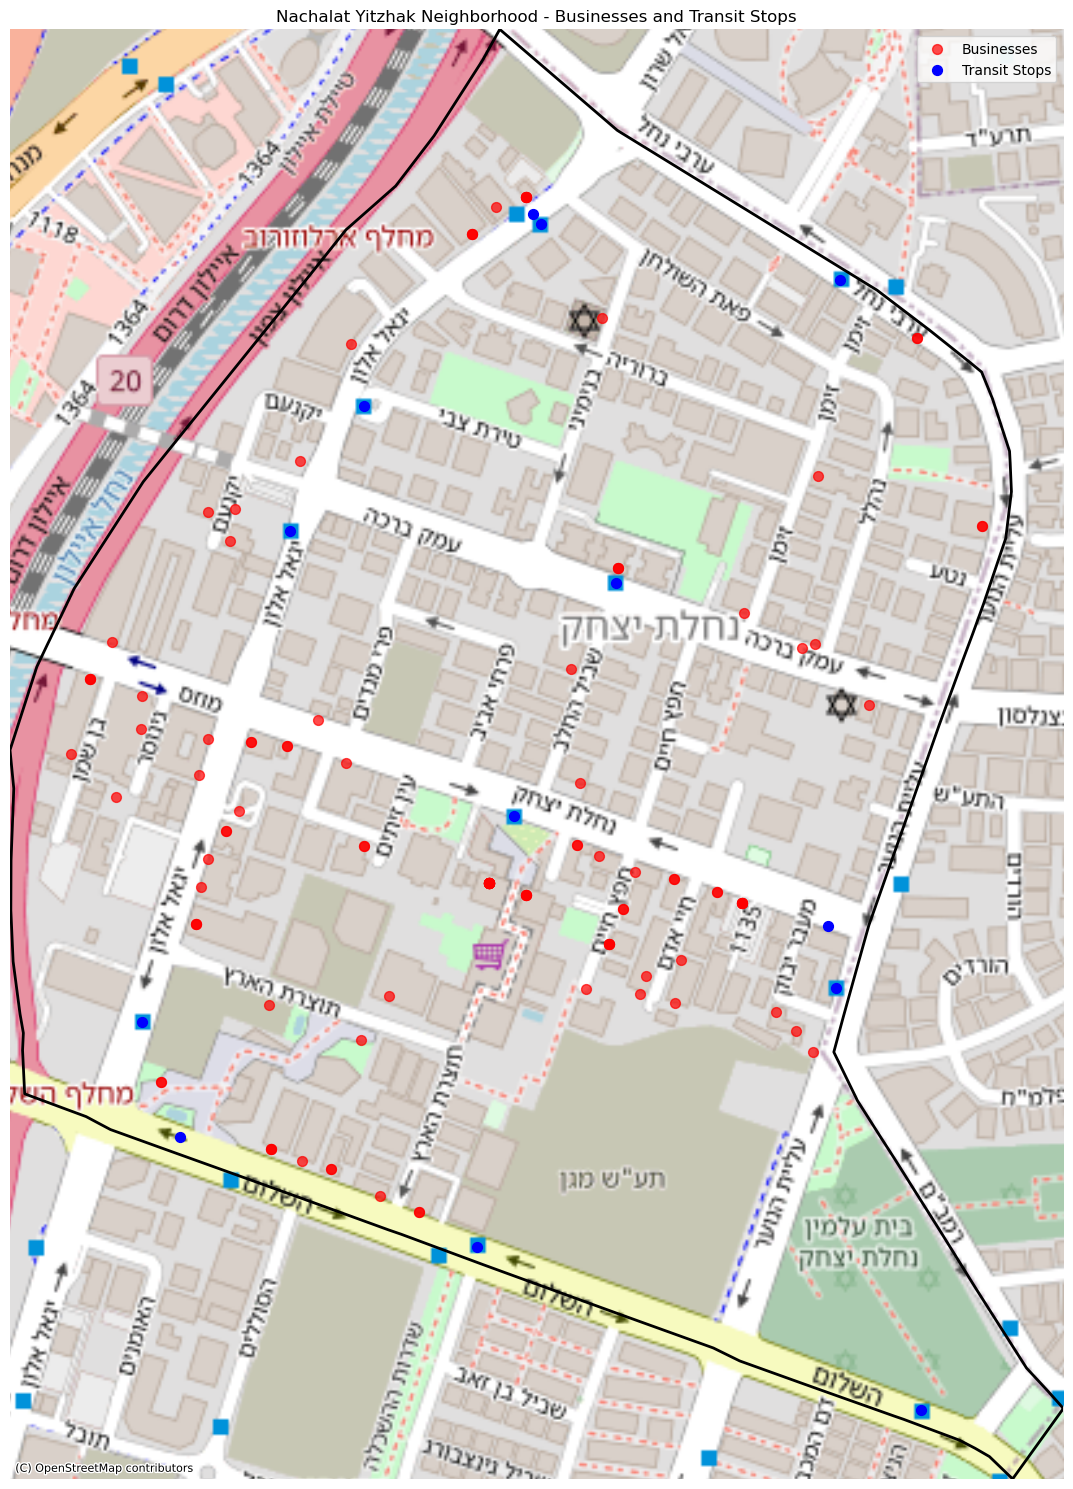

Number of businesses in the neighborhood: 113
Number of transit stops in the neighborhood: 13
Average distance from a business to the nearest transit stop: 115.45 meters


In [7]:
# Load neighborhood data
neighborhood = neigh_gdf_clean[neigh_gdf_clean['neighborhood_code'] == 57]

# Load business data
businesses = bus_gdf[bus_gdf.within(neighborhood.geometry.iloc[0])]

# Load and prepare stops data
stops_df = pd.read_csv('/Users/noamgal/Downloads/israel-public-transportation/stops.txt')
stops_gdf = gpd.GeoDataFrame(
    stops_df, 
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"
)

# Ensure all data is in the same CRS (Web Mercator for basemap compatibility)
neighborhood = neighborhood.to_crs("EPSG:3857")
businesses = businesses.to_crs("EPSG:3857")
stops_gdf = stops_gdf.to_crs("EPSG:3857")

# Filter stops within or near the neighborhood
stops_in_neighborhood = stops_gdf[stops_gdf.within(neighborhood.geometry.iloc[0])]

# Create plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot neighborhood boundary
neighborhood.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# Plot businesses
businesses.plot(ax=ax, color='red', markersize=50, alpha=0.7, label='Businesses')

# Plot transit stops
stops_in_neighborhood.plot(ax=ax, color='blue', markersize=50, label='Transit Stops')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Customize the plot
ax.set_title('Nachalat Yitzhak Neighborhood - Businesses and Transit Stops')
ax.legend()

# Set the extent of the plot to the neighborhood boundaries
ax.set_xlim(neighborhood.total_bounds[[0, 2]])
ax.set_ylim(neighborhood.total_bounds[[1, 3]])

# Remove axis labels
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of businesses in the neighborhood: {len(businesses)}")
print(f"Number of transit stops in the neighborhood: {len(stops_in_neighborhood)}")

# Calculate and print the average distance to the nearest transit stop
from shapely.ops import nearest_points

def distance_to_nearest_stop(point, stops):
    nearest_stop = nearest_points(point, stops.unary_union)[1]
    return point.distance(nearest_stop)

businesses['distance_to_stop'] = businesses.geometry.apply(lambda x: distance_to_nearest_stop(x, stops_in_neighborhood))

avg_distance = businesses['distance_to_stop'].mean()
print(f"Average distance from a business to the nearest transit stop: {avg_distance:.2f} meters")

In [8]:
# Extract data for neighborhood 57
neighborhood_57 = neigh_gdf_clean[neigh_gdf_clean['neighborhood_code'] == 57].iloc[0]

print("Analysis for Neighborhood 57:")

# List of metrics to analyze
metrics = ['business_count', 'driving_percent', 
           'walking_percent', 'transit_percent', 'shopping_percent',
           'distance_from_center', 'avg_income', 'median_age']

for metric in metrics:
    value = neighborhood_57[metric]
    mean_value = neigh_gdf_clean[metric].mean()
    median_value = neigh_gdf_clean[metric].median()
    std_dev = neigh_gdf_clean[metric].std()
    
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  Value for Neighborhood 57: {value:.2f}")
    print(f"  Mean across all neighborhoods: {mean_value:.2f}")
    print(f"  Median across all neighborhoods: {median_value:.2f}")
    print(f"  Standard deviation: {std_dev:.2f}")
    print(f"  Difference from mean: {((value - mean_value) / mean_value * 100):.2f}%")
    
    # Calculate and print the rank
    rank = neigh_gdf_clean[metric].rank(ascending=False)
    print(f"  Rank: {rank[neighborhood_57.name]} out of {len(neigh_gdf_clean)}")

Analysis for Neighborhood 57:

Business Count:
  Value for Neighborhood 57: 113.00
  Mean across all neighborhoods: 130.98
  Median across all neighborhoods: 47.00
  Standard deviation: 198.21
  Difference from mean: -13.73%
  Rank: 15.0 out of 57

Driving Percent:
  Value for Neighborhood 57: 54.89
  Mean across all neighborhoods: 55.48
  Median across all neighborhoods: 54.89
  Standard deviation: 12.40
  Difference from mean: -1.06%
  Rank: 29.0 out of 57

Walking Percent:
  Value for Neighborhood 57: 26.08
  Mean across all neighborhoods: 23.70
  Median across all neighborhoods: 23.19
  Standard deviation: 8.10
  Difference from mean: 10.08%
  Rank: 19.0 out of 57

Transit Percent:
  Value for Neighborhood 57: 12.06
  Mean across all neighborhoods: 11.98
  Median across all neighborhoods: 11.67
  Standard deviation: 4.95
  Difference from mean: 0.64%
  Rank: 28.0 out of 57

Shopping Percent:
  Value for Neighborhood 57: 4.27
  Mean across all neighborhoods: 6.33
  Median across all

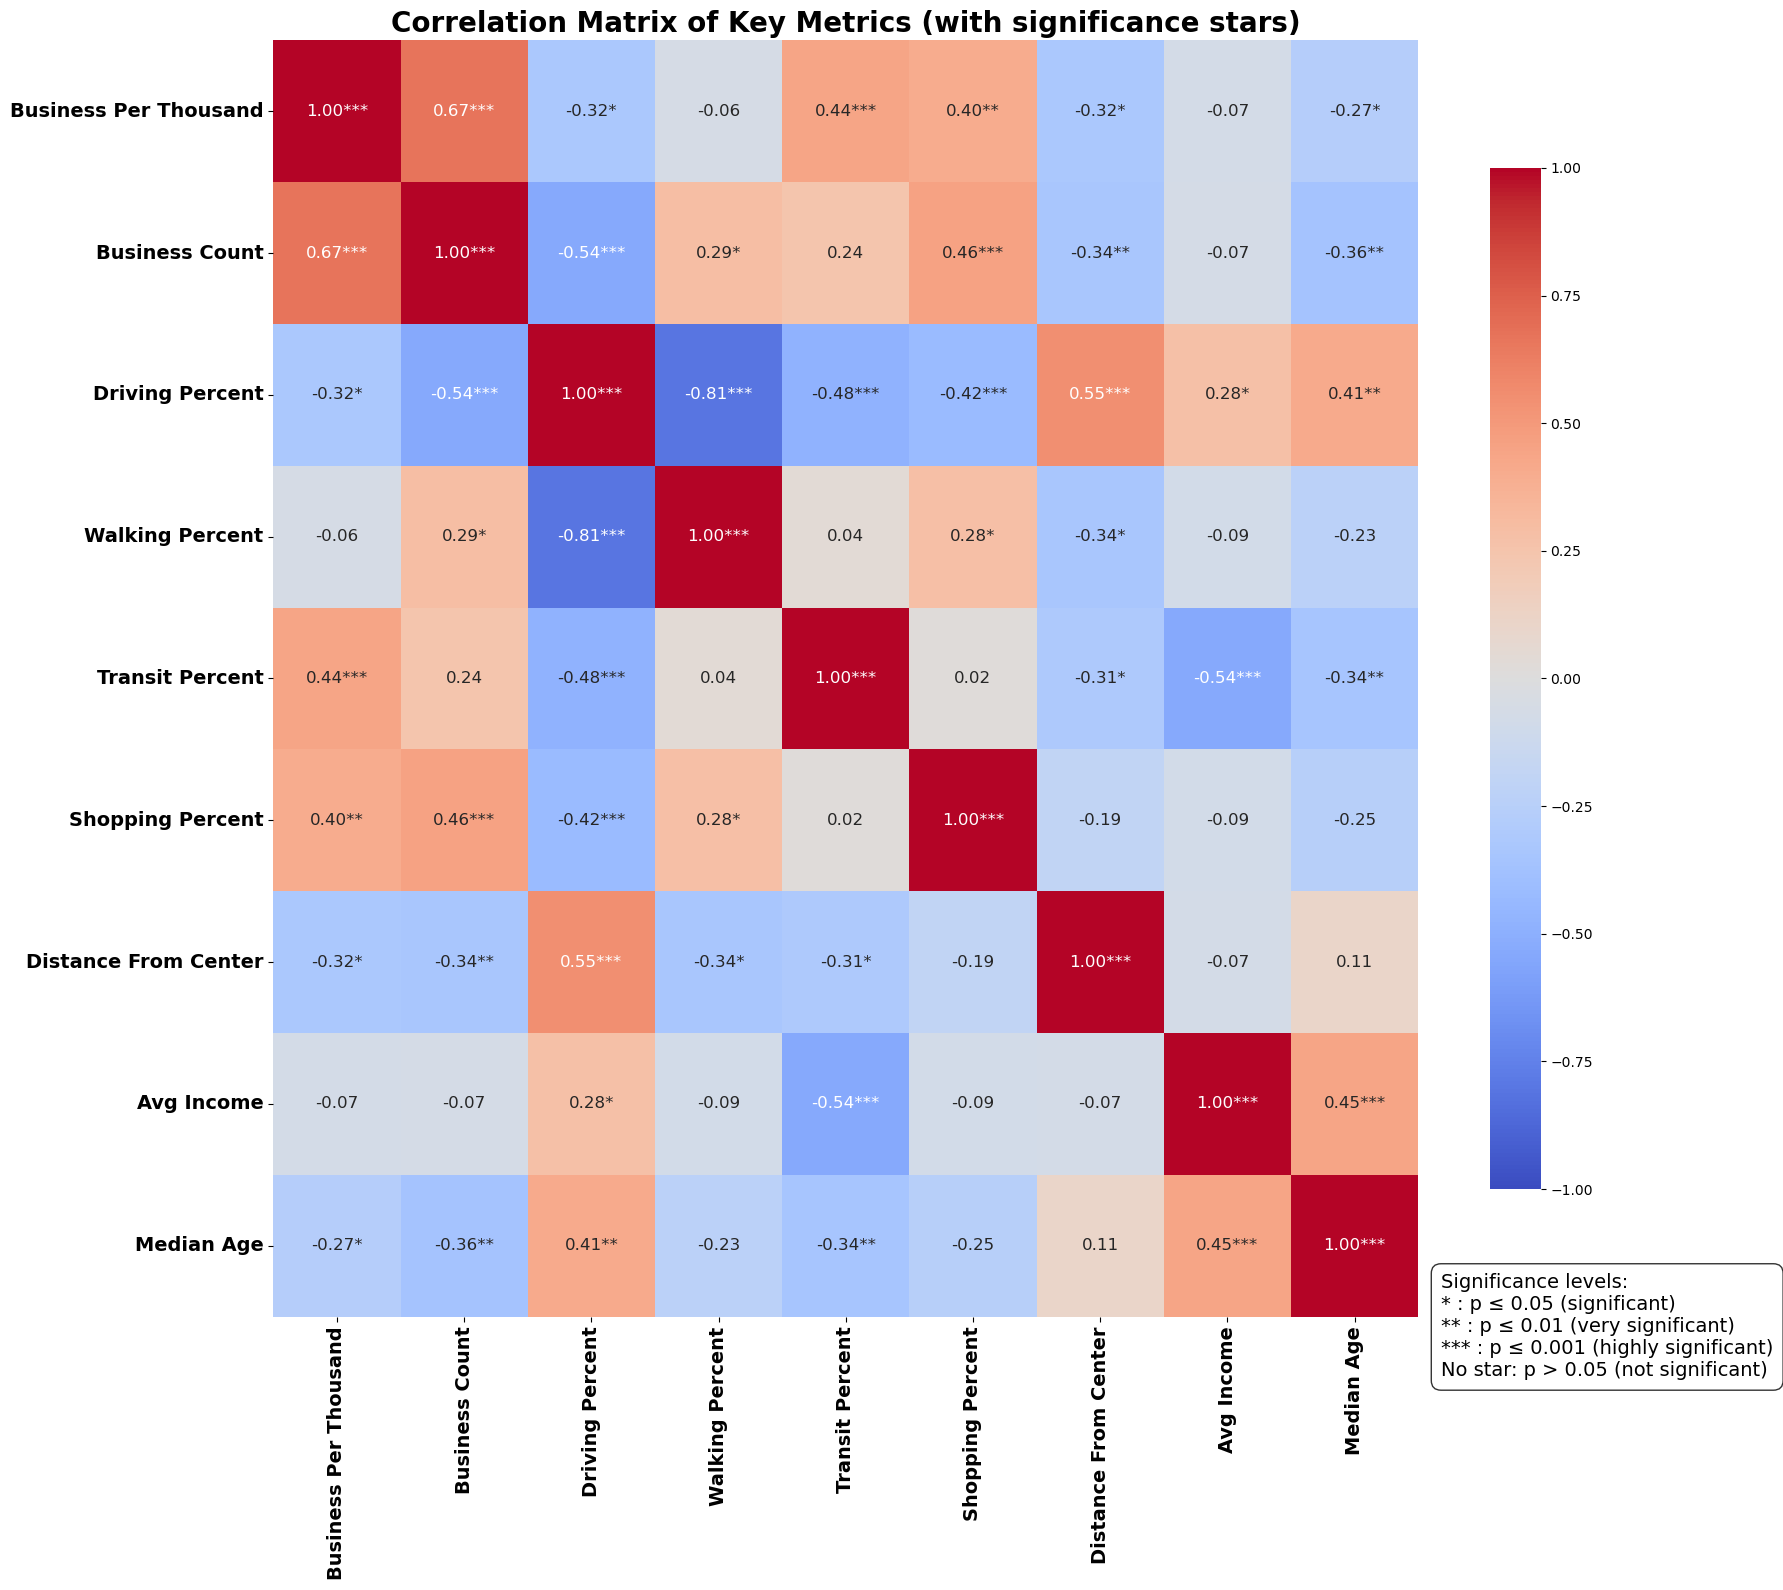


Correlation matrix heatmap with significance stars has been saved as 'correlation_matrix_heatmap_with_stars.png'

Correlation matrix with significance stars has been exported to 'neighborhood_metrics_correlation_with_stars.csv'


In [9]:
# List of metrics to analyze
metrics = ['business_per_thousand', 'business_count', 'driving_percent', 
           'walking_percent', 'transit_percent', 'shopping_percent',
           'distance_from_center', 'avg_income', 'median_age']

# Function to format column names
def format_column_name(name):
    return ' '.join(word.capitalize() for word in name.split('_'))

# Format metric names
formatted_metrics = [format_column_name(metric) for metric in metrics]

# Calculate the correlation matrix
correlation_matrix = neigh_gdf_clean[metrics].corr()

# Function to calculate p-values
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues.loc[r, c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

# Calculate p-values
p_values = calculate_pvalues(neigh_gdf_clean[metrics])

# Function to add stars for significance
def add_significance_stars(value, p_value):
    if p_value <= 0.001:
        return f"{value:.2f}***"
    elif p_value <= 0.01:
        return f"{value:.2f}**"
    elif p_value <= 0.05:
        return f"{value:.2f}*"
    else:
        return f"{value:.2f}"

# Create a new correlation matrix with stars
correlation_matrix_with_stars = correlation_matrix.map(lambda x: f"{x:.2f}")
for i in correlation_matrix.index:
    for j in correlation_matrix.columns:
        correlation_matrix_with_stars.loc[i, j] = add_significance_stars(correlation_matrix.loc[i, j], p_values.loc[i, j])

# Visualize the correlation matrix
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=correlation_matrix_with_stars, fmt='', cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=ax, 
            cbar_kws={'shrink': .8}, annot_kws={'size': 12})

# Increase font size for tick labels and use formatted names
plt.setp(ax.get_xticklabels(), fontsize=14, weight='bold')
plt.setp(ax.get_yticklabels(), fontsize=14, weight='bold')
ax.set_xticklabels(formatted_metrics)
ax.set_yticklabels(formatted_metrics)

plt.title('Correlation Matrix of Key Metrics (with significance stars)', fontsize=20, weight='bold')

# Add note explaining significance levels
note = "Significance levels:\n* : p ≤ 0.05 (significant)\n** : p ≤ 0.01 (very significant)\n*** : p ≤ 0.001 (highly significant)\nNo star: p > 0.05 (not significant)"
text = ax.text(1.02, -0.05, note, transform=ax.transAxes, fontsize=14, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.savefig('correlation_matrix_heatmap_with_stars.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation matrix heatmap with significance stars has been saved as 'correlation_matrix_heatmap_with_stars.png'")

# Export the correlation matrix with stars to a CSV file
correlation_matrix_with_stars.to_csv('neighborhood_metrics_correlation_with_stars.csv')
print("\nCorrelation matrix with significance stars has been exported to 'neighborhood_metrics_correlation_with_stars.csv'")

In [10]:
def safe_convert_to_string(value):
    if isinstance(value, bytes):
        try:
            return value.decode('utf-8')
        except UnicodeDecodeError:
            return '[BINARY_DATA]'
    elif pd.isna(value):
        return np.nan
    else:
        return str(value)

def clean_column_name(name):
    cleaned = ''.join(c for c in str(name)[:10] if c.isalnum() or c in ['_', '-']).rstrip()
    return cleaned if cleaned else 'column'

def make_column_names_unique(columns):
    seen = {}
    for i, col in enumerate(columns):
        if col in seen:
            seen[col] += 1
            columns[i] = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
    return columns

def convert_dtypes(gdf):
    for col in gdf.columns:
        if pd.api.types.is_datetime64_any_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(str)
        elif pd.api.types.is_object_dtype(gdf[col]):
            gdf[col] = gdf[col].apply(safe_convert_to_string)
        elif pd.api.types.is_integer_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(np.int32)
        elif pd.api.types.is_float_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(np.float32)
    return gdf

# Load data
neighborhood = neigh_gdf_clean[neigh_gdf_clean['neighborhood_code'] == 57]
businesses = bus_gdf[bus_gdf.within(neighborhood.geometry.iloc[0])]
stops_df = pd.read_csv('/Users/noamgal/Downloads/israel-public-transportation/stops.txt')
stops_gdf = gpd.GeoDataFrame(
    stops_df, 
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"
)

# Load walk survey data
gdb_path = '/Users/noamgal/Downloads/245117b2-9277-485e-b353-80e83ce75dfa.gdb'
walk_survey = gpd.read_file(gdb_path)

# Ensure all data is in the same CRS
neighborhood = neighborhood.to_crs("EPSG:3857")
businesses = businesses.to_crs("EPSG:3857")
stops_gdf = stops_gdf.to_crs("EPSG:3857")
walk_survey = walk_survey.to_crs("EPSG:3857")

# Filter stops within or near the neighborhood
buffer_distance = 500  # meters
neighborhood_buffer = neighborhood.buffer(buffer_distance)
stops_in_area = stops_gdf[stops_gdf.within(neighborhood_buffer.iloc[0])]

# Create a directory to store the shapefiles
output_dir = '/Users/noamgal/Downloads/neighborhood_analysis_shapefiles'
os.makedirs(output_dir, exist_ok=True)

# Clean and convert data
def process_gdf(gdf):
    gdf = gdf.rename(columns=clean_column_name)
    gdf.columns = make_column_names_unique(gdf.columns.tolist())
    return convert_dtypes(gdf)

neighborhood = process_gdf(neighborhood)
businesses = process_gdf(businesses)
stops_in_area = process_gdf(stops_in_area)
walk_survey = process_gdf(walk_survey)

# Export each dataset as a shapefile
neighborhood.to_file(os.path.join(output_dir, 'neighborhood_boundary.shp'))
businesses.to_file(os.path.join(output_dir, 'businesses.shp'))
stops_in_area.to_file(os.path.join(output_dir, 'bus_stops.shp'))
walk_survey.to_file(os.path.join(output_dir, 'walk_survey.shp'))

print(f"Shapefiles have been exported to: {output_dir}")

# Print statistics
print(f"\nNumber of businesses in the neighborhood: {len(businesses)}")
print(f"Number of transit stops in the area: {len(stops_in_area)}")
print(f"Number of features in walk survey: {len(walk_survey)}")
print("\nFeature counts in walk survey:")
print(walk_survey['feature'].value_counts() if 'feature' in walk_survey.columns else "Feature column not found")

Shapefiles have been exported to: /Users/noamgal/Downloads/neighborhood_analysis_shapefiles

Number of businesses in the neighborhood: 113
Number of transit stops in the area: 95
Number of features in walk survey: 16

Feature counts in walk survey:
feature
Car Feature        6
Business           5
Walking Feature    3
Housing Feature    2
Name: count, dtype: int64


/var/folders/82/8hysmmrd67z622hf9p3q3th80000gn/T/ipykernel_28339/610337280.py:79: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  neighborhood.to_file(os.path.join(output_dir, 'neighborhood_boundary.shp'))
